In [1]:
import math
import random
import numpy as np
import torch
from graphviz import Digraph

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data # stores the data
    self.grad = 0.0 # stores derivative
    self._backward = lambda: None # back-propagation
    self._prev = set(_children) # stores the prev value
    self._op = _op # operator which is used
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward(): # a + b
      #  we sum the derivative with the previous value as the same operator can be used multiple times
      self.grad += 1.0 * out.grad # da = 1 * out.grad
      other.grad += 1.0 * out.grad # db = 1 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward(): # a * b
      self.grad += other.data * out.grad # da = b * out.grad
      other.grad += self.data * out.grad # db = a * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward(): # a^b
        self.grad += other * (self.data ** (other - 1)) * out.grad # da = (b * a^(b-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self i.e. b * a
    return self * other

  def __truediv__(self, other): # self / other i.e b / a
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other i.e. a + (-b)
    return self + (-other)

  def __radd__(self, other): # other + self i.e, b + a
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward(): # tanh a
      self.grad += (1 - t**2) * out.grad # da = (sech a)^2 = 1 - (tanh a)^2
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward(): # e^a
      self.grad += out.data * out.grad # da = e^a
    out._backward = _backward

    return out

  def backward(self): # propagates to all the components and calculates the gradient
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
v = Value(3.0, label='v') # wraps in value label
v, v.label

(Value(data=3.0), 'v')

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;
e.label = 'e'
d = e + c;
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

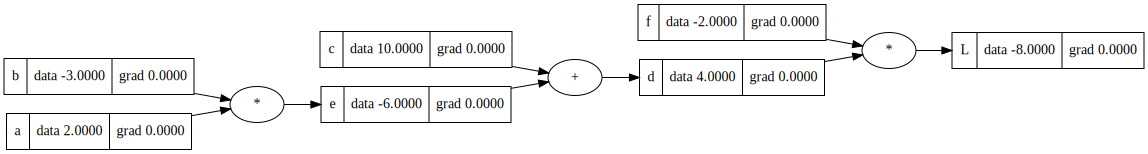

In [ ]:
draw_dot(L)

In [ ]:
L.backward()

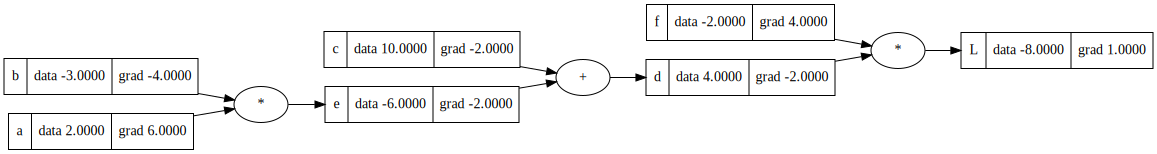

In [ ]:
draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation function
o = n.tanh(); o.label = 'o'

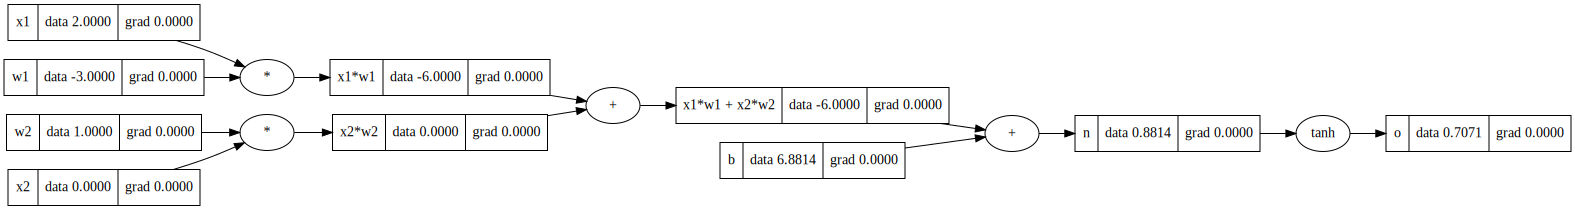

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

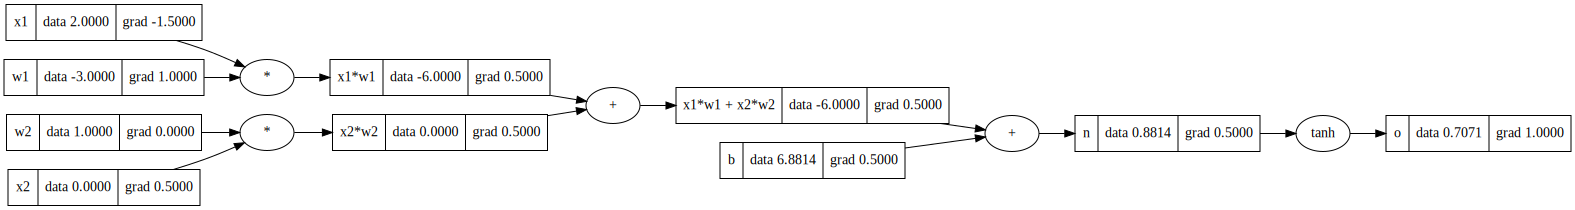

In [ ]:
draw_dot(o)

In [ ]:
# same thing but with pytorch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
class Neuron:
  # creates a neurons for n inputs and generates a output
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  # creates a single layer that takes n inputs and generates m outputs
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  # creates a MLP of multiple layers that takes nin and nouts of each layer
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# inputs- 3, 1st hidden layers- 4 neurons, 2nd hidden layer- 4 neurons, output- 1
n(x)

Value(data=0.9662452104307314)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20): # 20 epochs

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # need re-intialize the gradient back to zero before the backprop bcoz then the gradient of all the passes will acculumate together
  loss.backward()

  # update
  for p in n.parameters():
    # learning rate = 0.1
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 7.892063224461385
1 7.861852976656618
2 7.811808969466191
3 7.717300126160451
4 7.49707273357222
5 6.754522299147986
6 2.7997837421329392
7 2.3300408946416717
8 0.5974270762887536
9 0.01737957521588919
10 0.015868388478271496
11 0.014613228417037258
12 0.01355187453373756
13 0.012641087920141167
14 0.011849831656438142
15 0.011155213508366877
16 0.010539953236372274
17 0.009990744116081748
18 0.009497159913988192
19 0.009050906018303015


In [ ]:
ypred

[Value(data=0.9636776211617896),
 Value(data=-0.9532401581153757),
 Value(data=-0.9600869509498596),
 Value(data=0.9371346159139821)]